<center> Python implementation of Kernel Current Source Density (kCSD) method - TUTORIAL </center>
======

In [48]:
%load_ext autoreload
%autoreload 2

from ipywidgets import interact
import numpy as np
import config

import plotting_helpers as plots
from widget_helpers import dim_select, csd_select, kcsd_select, accordion, nr_ele_select, nr_broken_ele, noise_select, regularization_select

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Select dimensions of your setup

dim_select

ToggleButtons(description='Dimensions of the setup:', options=('1D', '2D', '3D'), tooltips=['Laminar probes', 'MEA like flat electrodes', 'Utah array or SEEG'], value='1D')

In [3]:
# Select a type of CSD source

csd_select


ToggleButtons(description='True source type', options=('monopole gauss', 'dipole gauss'), value='monopole gauss')

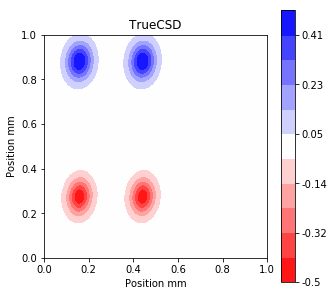

In [37]:
val = config.ValidateKCSD(dim=int(dim_select.value[0]))
csd_at, true_csd = val.generate_csd(config.csd_profile, csd_seed=5)
plots.show_csd(csd_at, true_csd)

In [38]:
# Select number of electrodes

nr_ele_select

BoundedIntText(value=16, description='Select nr of electrodes:', max=200, min=1)

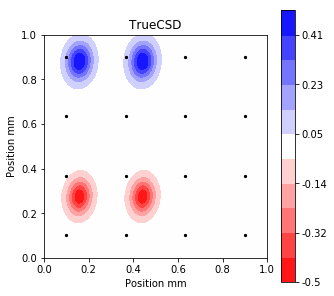

In [39]:
ele_pos = val.generate_electrodes(total_ele=nr_ele_select.value, ele_lims=[0.1, 0.9])
plots.show_csd(csd_at, true_csd, show_ele=ele_pos)

/home/mkowalska/Marta/kCSD-python/ipynb_tests/tutorials/plotting_helpers.py:155: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  zz = griddata(x, y, z, xx, yy, interp='linear')


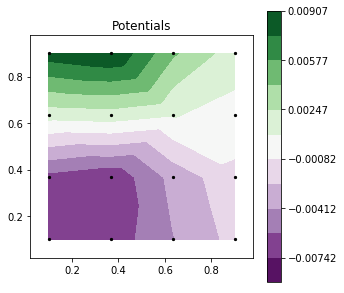

In [40]:
h = 0.25
sigma = 0.3
pots = val.calculate_potential(true_csd, csd_at, ele_pos, h, sigma)
plots.show_pot(ele_pos, pots)

In [41]:
# Do you want to investigate data with noise or without?

noise_select

Select(description='Noise:', options=(None, 'noise'), value=None)

In [42]:
if noise_select.value == 'noise':
    pots = val.add_noise(pots, 5)

In [43]:
kcsd_select

ToggleButtons(description='KCSD method', options=('ValidateKCSD2D', 'MoIKCSD'), value='ValidateKCSD1D')

In [44]:
# Call the main class with parameters of ground truth data and measurement setup

k = config.kCSD(csd_seed=5, **config.defaults[config.kCSD.__name__])

In [45]:
# Choose regularization method: cross-validation or L-curve

regularization_select

Select(description='Regularization method:', options=('cross-validation', 'L-curve'), value='cross-validation')

No lambda given, using defaults
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
R, lambda : 0.4 4.64158883361e-18


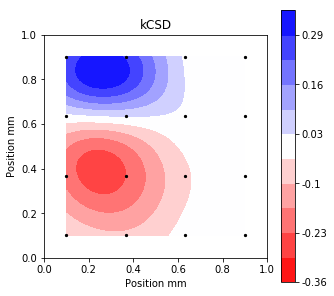

In [49]:
# Estimate current source density, change value of Rs to fit the best solution using crossvalidation

obj, est_csd = k.recon(pots, ele_pos, method=regularization_select.value, Rs=np.arange(0.2, 0.5, 0.1))
plots.show_csd(obj.estm_pos, est_csd, show_ele=ele_pos, show_kcsd=True)

In [50]:
# Investigate spectral structure of kCSD reconstruction

structure = config.SpectralStructure(obj)

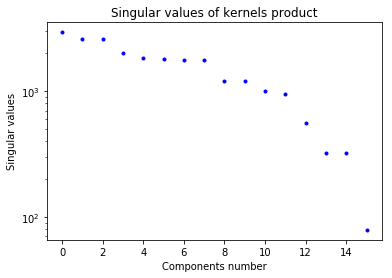

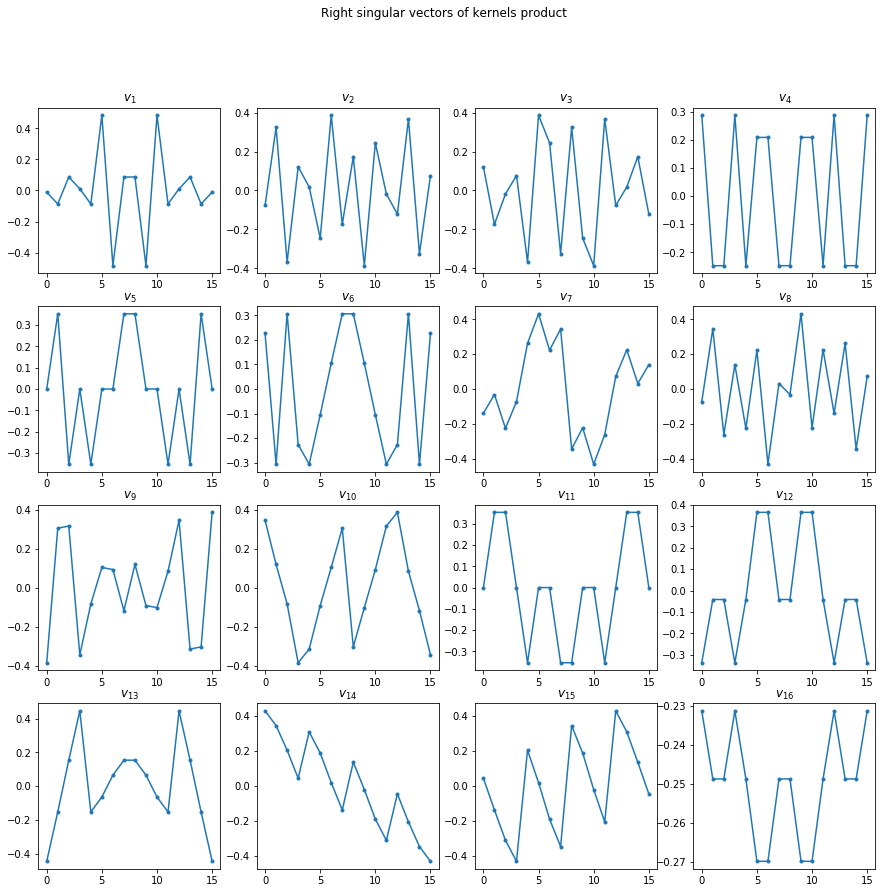

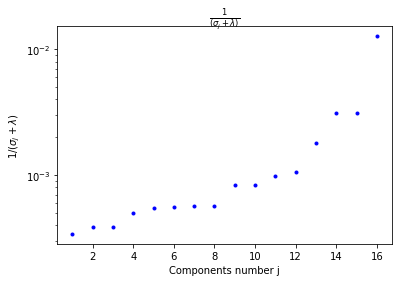

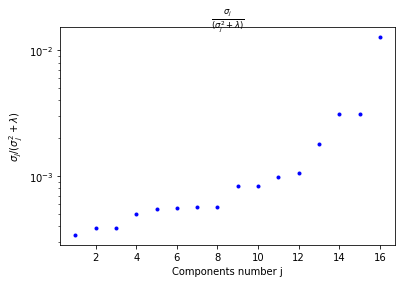

In [51]:
u_svd, sigma, v_svd = structure.svd()

Visibility maps
------

In [52]:
vmap = config.visibility_map(**config.defaults[config.kCSD.__name__])

#### Calculate errors for Visibility Map

It may take a few minutes.

In [ ]:
# n - number of (pseudo) random sources included in calculation of error map 

rms, point_error = vmap.calculate_error_map(config.csd_profile, total_ele=nr_ele_select.value,
                                            n=150, Rs=np.arange(0.2, 0.5, 0.1))

Number of electrodes: 16
Number of electrodes: 16
Number of electrodes: 16
Number of electrodes: 16
Number of electrodes: 16
Number of electrodes: 16
Number of electrodes: 16
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda)

In [54]:
print(point_error.shape)

(50, 100, 100)


(100, 100)


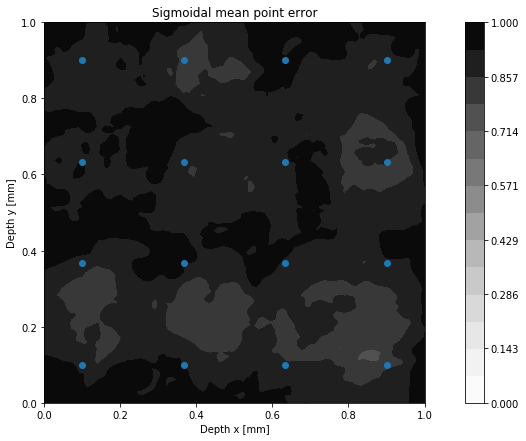

In [55]:
vmap.plot_error_map(point_error, ele_pos)

In [56]:
# Choose how many electrodes are broken

nr_broken_ele

BoundedIntText(value=2, description='Select number of broken electrodes:', max=9, min=1)

In [57]:
ele_pos_br = vmap.generate_electrodes(total_ele=nr_ele_select.value, ele_lims=[0.1, 0.9],
                                      nr_broken_ele=nr_broken_ele.value)

In [58]:
rms_br, point_error_br = vmap.calculate_error_map(config.csd_profile, total_ele=nr_ele_select.value,
                                                  n=150, Rs=np.arange(0.2, 0.5, 0.1),
                                                  nr_broken_ele=nr_broken_ele.value)

Number of electrodes: 14
Number of electrodes: 14
Number of electrodes: 14
Number of electrodes: 14
Number of electrodes: 14
Number of electrodes: 14
Number of electrodes: 14
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda)

Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.4
R, lambda : 0.4 0.000121152765863
Number of electrodes: 14
R, lambda : 0.4 5.10896977451e-19
Number of electrodes: 14
R, lambda : 0.2 0.01
R, lambda : 0.4 0.00110069417125
Number of electrodes: 14
Number of electrodes: 14
R, lambda : 0.2 0.00110069417125
Number of electrodes: 14
R, lambda : 0.3 5.10896977451e-19
Number of electrodes: 14
R, lambda : 0.3 4.64158883361e-18
No lambda given, using defaults
Number of electrodes: 14
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
Cross validating R (all lambda) : 0.2
No lambda given, using defaults
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.

Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.3
R, lambda : 0.3 1.33352143216e-05
R, lambda : 0.4 1.46779926762e-06
R, lambda : 0.2 0.000121152765863
Number of electrodes: 14
Number of electrodes: 14
Number of electrodes: 14
Cross validating R (all lambda) : 0.4
R, lambda : 0.4 1.46779926762e-06
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.4
Number of electrodes: 14
No lambda given, using defaults
No lambda given, using defaults
No lambda given, using defaults
R, lambda : 0.2 0.000121152765863
Number of electrodes: 14
R, lambda : 0.4 0.000121152765863
No lambda given, using defaults
Number of electrodes: 14
R, lambda : 0.3 0.00110069417125
Number of electrodes: 14
Cross validating R (all lambda) : 0.2
Cros

Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.2
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.4
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.3
Cross validating R (all lambda) : 0.4
R, lambda : 0.4 0.00110069417125
Number of electrodes: 14
Cross validating R (all lambda) : 0.4
R, lambda : 0.2 0.00110069417125
Number of electrodes: 14
R, lambda : 0.2 0.01
Cross validating R (all lambda) : 0.4
Number of electrodes: 14
Cross validating R (all lambda) : 0.4
R, lambda : 0.4 5.10896977451e-19
Number of electrodes: 14
No lambda given, using defaults
R, lambda : 0.4 5.10896977451e-19
Number of electrodes: 14
No l

(100, 100)


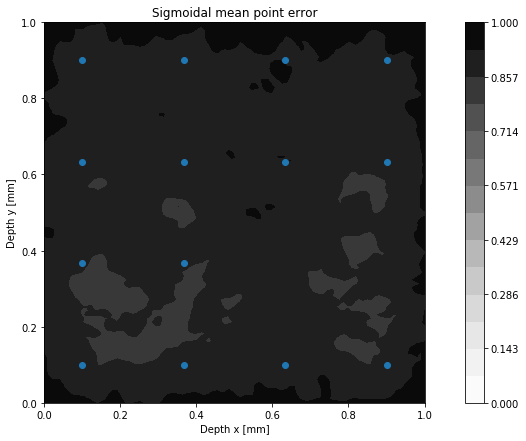

In [59]:
vmap.plot_error_map(point_error_br, ele_pos_br)